In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, roc_curve, 
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import datetime

In [29]:
# Load the dataset
try:
    df_train = pd.read_csv("credit-card-fraud-detection/fraudTest.csv")
    df_test = pd.read_csv("credit-card-fraud-detection/fraudTest.csv")
except Exception as e:
    print(f"Error loading dataset: {e}")


In [30]:
df_train.info(),df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179033 entries, 0 to 179032
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             179033 non-null  int64  
 1   trans_date_trans_time  179033 non-null  object 
 2   cc_num                 179033 non-null  int64  
 3   merchant               179033 non-null  object 
 4   category               179033 non-null  object 
 5   amt                    179033 non-null  float64
 6   first                  179033 non-null  object 
 7   last                   179033 non-null  object 
 8   gender                 179033 non-null  object 
 9   street                 179033 non-null  object 
 10  city                   179033 non-null  object 
 11  state                  179033 non-null  object 
 12  zip                    179033 non-null  int64  
 13  lat                    179033 non-null  float64
 14  long                   179033 non-nu

(None, None)

In [33]:
df_train.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,179033.000000,1.790330e+05,179033.000000,179033.000000,179033.000000,179033.000000,1.790330e+05,1.790320e+05,179032.000000,179032.000000,179032.000000
mean,89516.000000,4.198395e+17,69.311017,48825.548525,38.548633,-90.218091,8.853991e+04,1.374496e+09,38.547267,-90.216765,0.004239
std,51682.519709,1.312661e+18,147.182674,26858.062413,5.067815,13.727662,3.008696e+05,1.572313e+06,5.103971,13.741509,0.064973
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.039532,-166.671575,0.000000
25%,44758.000000,1.800429e+14,9.660000,26237.000000,34.690200,-96.798000,7.410000e+02,1.373130e+09,34.764426,-96.885817,0.000000
50%,89516.000000,3.519607e+15,47.420000,48174.000000,39.371600,-87.476900,2.408000e+03,1.374443e+09,39.379704,-87.422300,0.000000
75%,134274.000000,4.634956e+15,83.070000,72042.000000,41.940400,-80.175200,1.968500e+04,1.375871e+09,41.963078,-80.253400,0.000000
max,179032.000000,4.992346e+18,13149.150000,99783.000000,65.689900,-67.950300,2.906700e+06,1.377261e+09,66.669356,-66.952352,1.000000


In [35]:
df_train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                1
merch_lat                1
merch_long               1
is_fraud                 1
dtype: int64

In [37]:
print(df_train['is_fraud'].value_counts())

is_fraud
0.0    178273
1.0       759
Name: count, dtype: int64


In [39]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1.371817e+09,33.986391,-81.200714,0.0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1.371817e+09,39.450498,-109.960431,0.0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1.371817e+09,40.495810,-74.196111,0.0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1.371817e+09,28.812398,-80.883061,0.0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1.371817e+09,44.959148,-85.884734,0.0


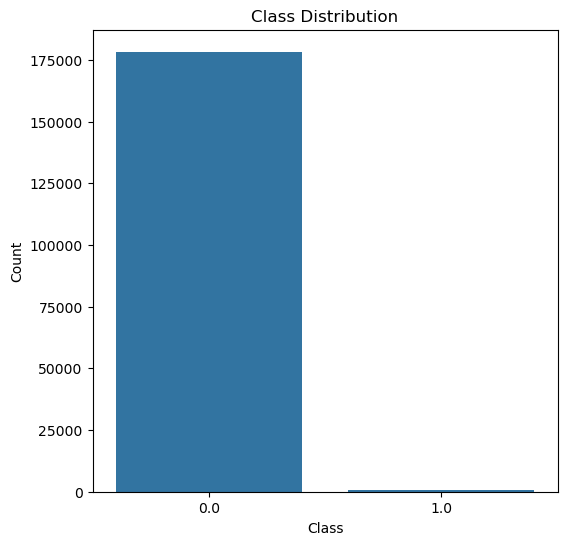

In [41]:
# Visualize the class distribution
plt.figure(figsize=(6,6))
sns.countplot(x='is_fraud', data=df_train)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

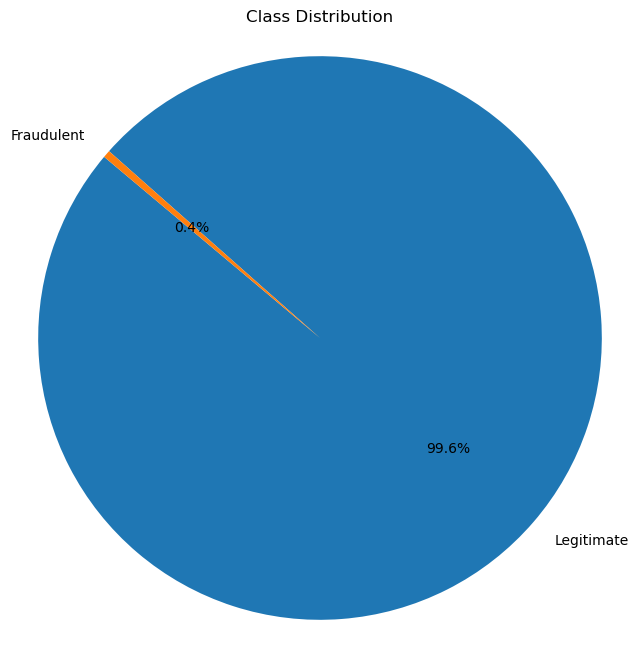

In [43]:
plt.figure(figsize=(8,8))
labels = ['Legitimate', 'Fraudulent']
sizes = df_train['is_fraud'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

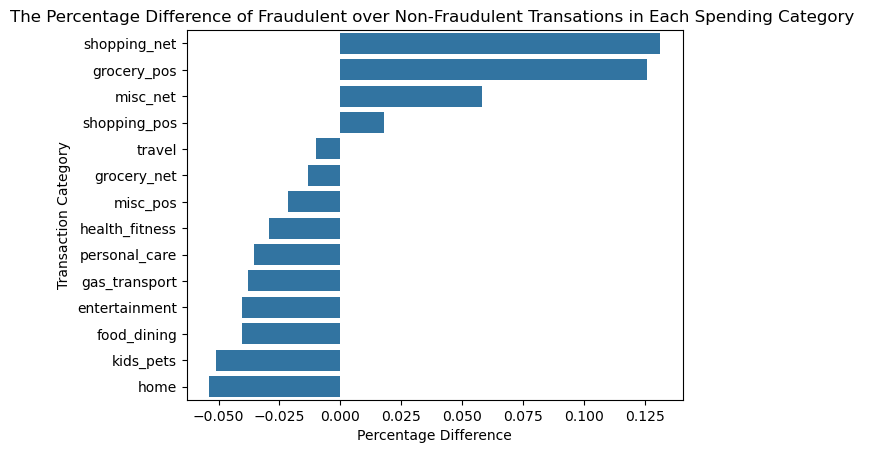

In [45]:
a=df_train[df_train['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=df_train[df_train['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')
     

In [47]:
df_train["trans_date_trans_time"]=pd.to_datetime(df_train["trans_date_trans_time"])
df_train["dob"]=pd.to_datetime(df_train["dob"])
df_train

df_test["trans_date_trans_time"]=pd.to_datetime(df_test["trans_date_trans_time"])
df_test["dob"]=pd.to_datetime(df_test["dob"])
df_test

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1.371817e+09,33.986391,-81.200714,0.0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1.371817e+09,39.450498,-109.960431,0.0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1.371817e+09,40.495810,-74.196111,0.0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1.371817e+09,28.812398,-80.883061,0.0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1.371817e+09,44.959148,-85.884734,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179028,179028,2020-08-23 12:34:13,4383521454815,"fraud_Labadie, Treutel and Bode",shopping_net,2.08,John,Robertson,M,209 Austin Stream Apt. 231,...,39.9347,-86.1633,910148,Academic librarian,1987-09-22,4a3d261607f42ce9ed55a9ee0e772aa5,1.377261e+09,40.090340,-85.605158,0.0
179029,179029,2020-08-23 12:34:52,3533012926413100,fraud_Christiansen-Gusikowski,misc_pos,303.17,Megan,Bernard,F,128 Nathan Ramp,...,43.2237,-75.1612,1684,IT trainer,1994-03-01,bf12e351526d826ab3fc46a4a71ca5ad,1.377261e+09,43.984395,-75.170714,0.0
179030,179030,2020-08-23 12:35:18,3527063666782582,fraud_Bogisich-Weimann,kids_pets,96.39,Amanda,Alexander,F,21810 James Mall,...,30.9000,-94.7547,99,Colour technologist,1965-11-21,afcb44b3a629f963e5de6d78cbb6dc76,1.377261e+09,30.770977,-93.797228,0.0
179031,179031,2020-08-23 12:35:25,630451534402,fraud_Kihn-Schuster,food_dining,7.61,Rachel,Daniels,F,561 Little Plain Apt. 738,...,46.3535,-86.6345,765,Immunologist,1972-06-12,c161dae2c67cea40ca9422341f156410,1.377261e+09,47.185185,-87.266083,0.0


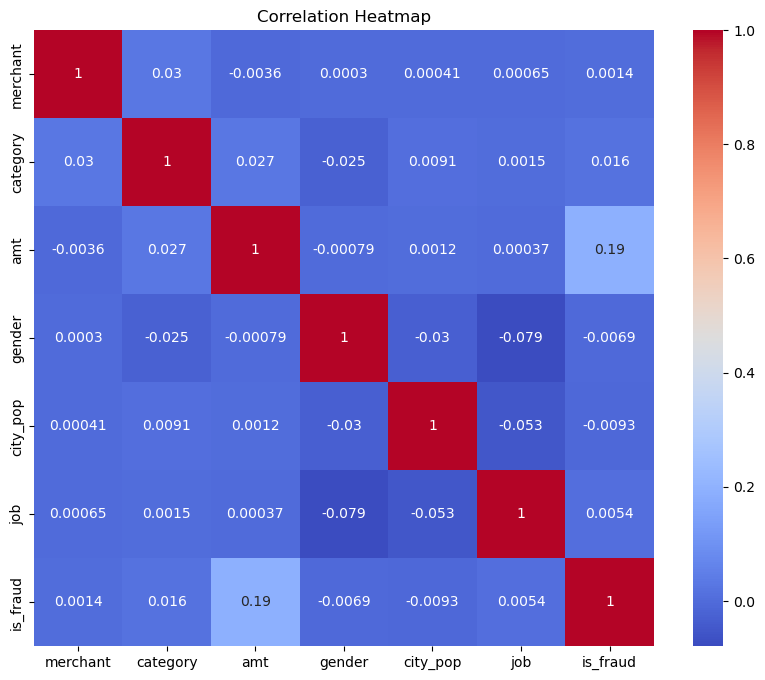

In [79]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
df_encoded = df_train.copy()
for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])

correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [81]:
# List of columns to drop
drop_columns = ['Unnamed: 0', 'cc_num', 'trans_num', 'unix_time', 'first', 'last', 'street', 'zip', 'trans_date_trans_time', 'city', 'lat', 'long', 'dob', 'merch_lat', 'merch_long', 'state']

# Check and drop columns if they exist in the DataFrame
df_train = df_train.drop(columns=[col for col in drop_columns if col in df_train.columns], errors='ignore')
df_test = df_test.drop(columns=[col for col in drop_columns if col in df_test.columns], errors='ignore')

# Print the DataFrame and its shape
print(df_train.head())
print(df_train.shape)

print(df_test.head(5))
print(df_test.shape)


   merchant  category  amt  gender  city_pop  job  is_fraud
0       319        10    2       1    333497  275       0.0
1       591        10   29       0       302  391       0.0
2       611         5   41       0     34496  259       0.0
3       222         9   60       1     54767  406       0.0
4       292        13    3       1      1126  196       0.0
(179032, 7)
   merchant  category    amt  gender  city_pop  job  is_fraud
0       319        10   2.86       1    333497  275       0.0
1       591        10  29.84       0       302  391       0.0
2       611         5  41.28       0     34496  259       0.0
3       222         9  60.05       1     54767  406       0.0
4       292        13   3.19       1      1126  196       0.0
(179032, 7)


In [83]:
encoder = LabelEncoder()
df_train["gender"]=encoder.fit_transform(df_train["gender"])
df_test["gender"]=encoder.fit_transform(df_test["gender"])

df_train["category"]=encoder.fit_transform(df_train["category"])
df_test["category"]=encoder.fit_transform(df_test["category"])

df_train["job"]=encoder.fit_transform(df_train["job"])
df_test["job"]=encoder.fit_transform(df_test["job"])

df_train["merchant"]=encoder.fit_transform(df_train["merchant"])
df_test["merchant"]=encoder.fit_transform(df_test["merchant"])
# Assuming your DataFrame is named df
df_train['amt'] = df_train['amt'].astype(int)

# Fill missing values
df_train.fillna(-999, inplace=True)
df_test.fillna(-999, inplace=True)
df_test.fillna(-999,inplace=True)
df_test.fillna(-999,inplace=True)

# Drop rows containing -999 in df_train
df_train = df_train[df_train != -999].dropna()

# Drop rows containing -999 in df_test
df_test = df_test[df_test != -999].dropna()

In [85]:
x_train = df_train.drop('is_fraud',axis=1)
y_train = df_train['is_fraud']

x_test=df_test.drop('is_fraud',axis=1)
y_test = df_test['is_fraud']

In [87]:
df_train.head()
df_test.head()

,merchant,category,amt,gender,city_pop,job,is_fraud
0,319,10,2.86,1,333497,275,0.0
1,591,10,29.84,0,302,391,0.0
2,611,5,41.28,0,34496,259,0.0
3,222,9,60.05,1,54767,406,0.0
4,292,13,3.19,1,1126,196,0.0


In [89]:
print(x_train.dtypes)
print(y_train.dtypes)

merchant    int64
category    int64
amt         int32
gender      int64
city_pop    int64
job         int64
dtype: object
float64


In [91]:
from sklearn.ensemble import RandomForestClassifier

cla=RandomForestClassifier(n_estimators=100,random_state=42)
cla.fit(x_train,y_train)

y_pred=cla.predict(x_test)

report = classification_report(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy)
print("Classification Report : ",report)

Accuracy:  0.9997709906608875
Classification Report :                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    178273
         1.0       1.00      0.95      0.97       759

    accuracy                           1.00    179032
   macro avg       1.00      0.97      0.99    179032
weighted avg       1.00      1.00      1.00    179032



Logistic Regression Accuracy: 0.9954365699986595
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    178273
         1.0       0.00      0.00      0.00       759

    accuracy                           1.00    179032
   macro avg       0.50      0.50      0.50    179032
weighted avg       0.99      1.00      0.99    179032



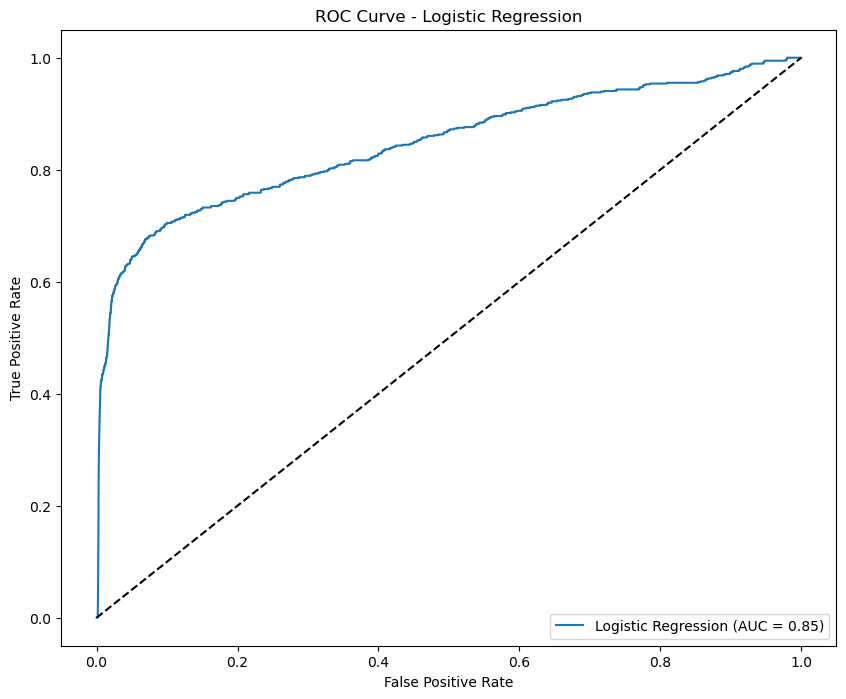

Logistic Regression Cross-Validation Accuracy: 0.995442155217059


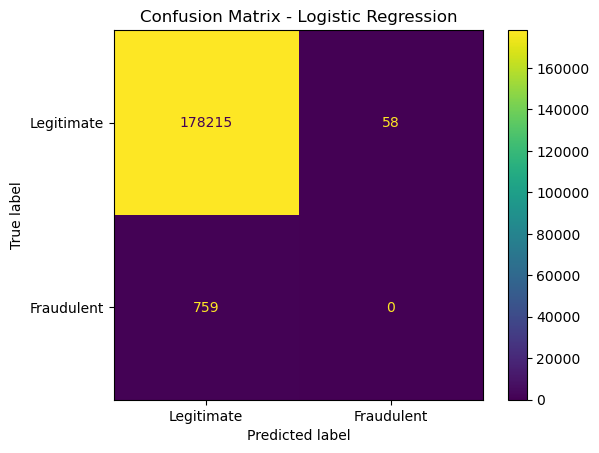

In [92]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train, y_train)
lr_predictions = lr_model.predict(x_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)
print(classification_report(y_test, lr_predictions))
lr_probs = lr_model.predict_proba(x_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(lr_model, x_train, y_train, cv=5)
print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(lr_cv_scores)}")

# Confusion matrix for Logistic Regression

# Generate predictions
y_pred = lr_model.predict(x_test)

# Confusion matrix for Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


Decision Tree Accuracy: 0.999123061799008
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    178273
         1.0       0.85      0.96      0.90       759

    accuracy                           1.00    179032
   macro avg       0.92      0.98      0.95    179032
weighted avg       1.00      1.00      1.00    179032



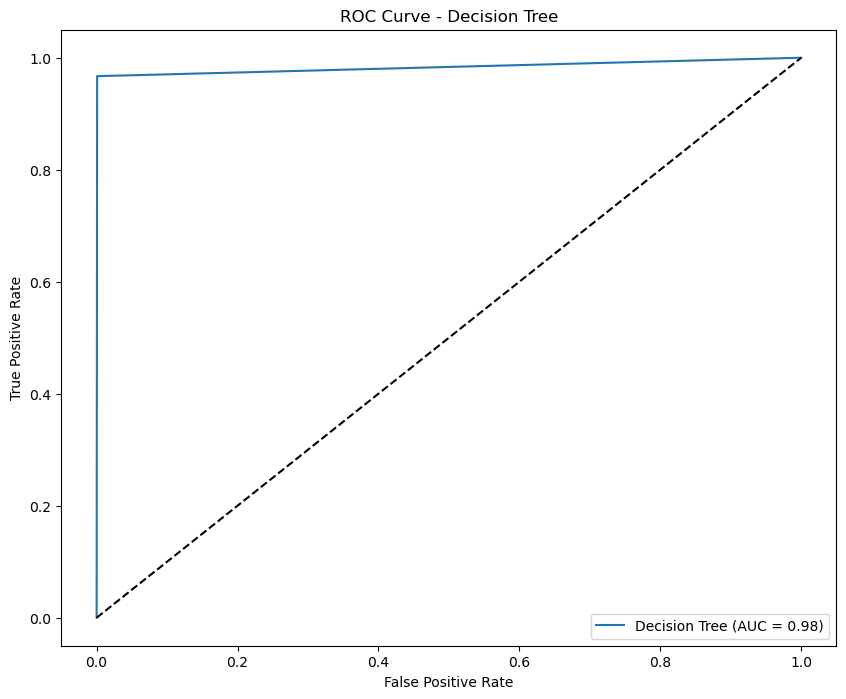

Decision Tree Cross-Validation Accuracy: 0.9959169313002573


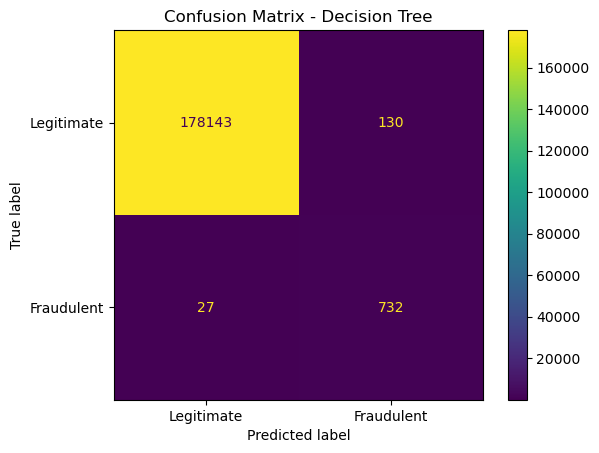

In [93]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)
dt_predictions = dt_model.predict(x_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)
print(classification_report(y_test, dt_predictions))
dt_probs = dt_model.predict_proba(x_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
plt.figure(figsize=(10, 8))
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()

# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(dt_model, x_train, y_train, cv=5)
print(f"Decision Tree Cross-Validation Accuracy: {np.mean(dt_cv_scores)}")


# Confusion matrix for Decision Tree

ConfusionMatrixDisplay.from_estimator(dt_model, x_test, y_test, display_labels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix - Decision Tree')
plt.show()


Random Forest Accuracy: 0.9997709906608875
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    178273
         1.0       1.00      0.95      0.97       759

    accuracy                           1.00    179032
   macro avg       1.00      0.97      0.99    179032
weighted avg       1.00      1.00      1.00    179032



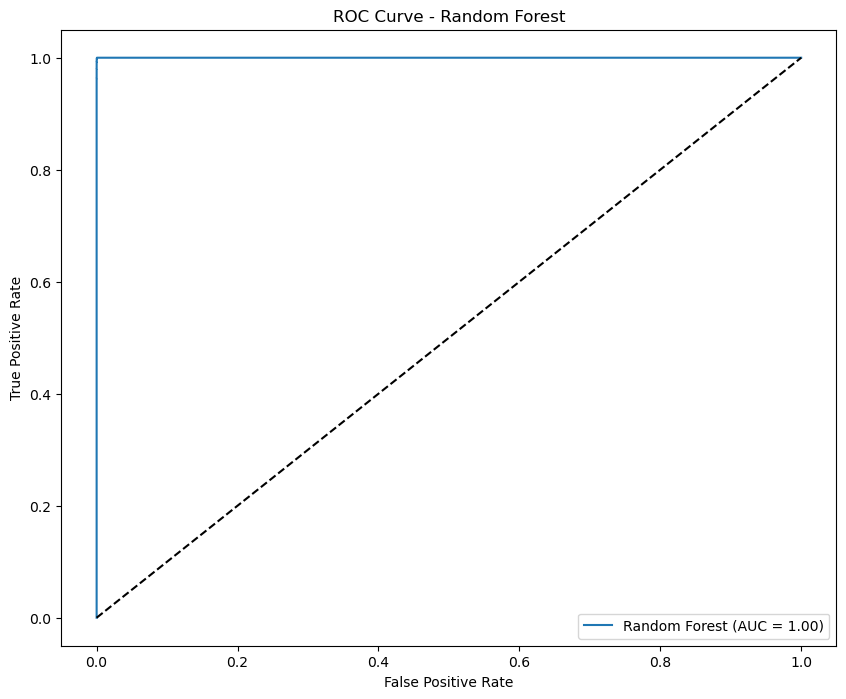

Random Forest Cross-Validation Accuracy: 0.9969279250590686


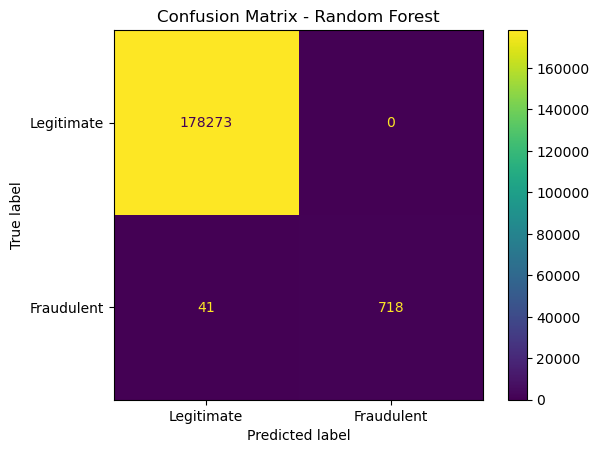

In [94]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_predictions))
rf_probs = rf_model.predict_proba(x_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, x_train, y_train, cv=5)
print(f"Random Forest Cross-Validation Accuracy: {np.mean(rf_cv_scores)}")

# Confusion matrix for Random Forest

# Generate predictions
y_pred = rf_model.predict(x_test)

# Confusion matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [95]:
# Compare results and display the most accurate classifier
print("Comparison of Model Performance:")
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")

accuracies = {'Logistic Regression': lr_accuracy, 'Decision Tree': dt_accuracy, 'Random Forest': rf_accuracy}
best_model = max(accuracies, key=accuracies.get)
print(f"The most accurate classifier is: {best_model} with an accuracy of {accuracies[best_model]}")

Comparison of Model Performance:
Logistic Regression Accuracy: 0.9954365699986595
Decision Tree Accuracy: 0.999123061799008
Random Forest Accuracy: 0.9997709906608875
The most accurate classifier is: Random Forest with an accuracy of 0.9997709906608875
